# Artistic QR Code Generation on Kaggle

This notebook generates artistic images with embedded scannable QR codes using Stable Diffusion and ControlNet.

## Features
- Generate artistic images with embedded QR codes
- Support for both ControlNet and post-processing embedding methods
- Automatic QR code validation
- GPU acceleration support


In [1]:
# Install required packages
# Core ML libraries
!pip install -q diffusers>=0.21.0 transformers>=4.30.0 accelerate>=0.20.0

# Image processing
!pip install -q qrcode[pil]>=7.4.2 Pillow>=10.0.0

# QR code validation (OpenCV is more reliable on Kaggle than pyzbar)
!pip install -q opencv-python-headless>=4.8.0

# Optional: Scientific computing (for edge enhancement)
!pip install -q scipy numpy

# Note: pyzbar requires system libraries (libzbar) that are not available on Kaggle
# QR validation uses OpenCV instead, which works reliably in Kaggle environment


In [106]:
# Import libraries
import os
import qrcode
import torch
import numpy as np
from PIL import Image
from diffusers import StableDiffusionPipeline, StableDiffusionControlNetPipeline, ControlNetModel
from typing import Optional
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Using device: cuda
GPU: Tesla T4
GPU Memory: 15.64 GB


In [107]:
# Kaggle-specific paths
KAGGLE_WORKING = "/kaggle/working"
KAGGLE_INPUT = "/kaggle/input"
OUTPUT_DIR = os.path.join(KAGGLE_WORKING, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set up Hugging Face cache (use working directory)
HF_CACHE = os.path.join(KAGGLE_WORKING, "hf_cache")
os.makedirs(HF_CACHE, exist_ok=True)
os.environ["HF_HOME"] = HF_CACHE
os.environ["HF_HUB_CACHE"] = os.path.join(HF_CACHE, "hub")

print(f"Output directory: {OUTPUT_DIR}")
print(f"HF Cache: {HF_CACHE}")


Output directory: /kaggle/working/outputs
HF Cache: /kaggle/working/hf_cache


In [108]:
# Artistic QR Pipeline Class (Kaggle-adapted)
class ArtisticQRPipeline:
    """Complete pipeline for generating artistic images with embedded QR codes."""
    
    def __init__(self, 
                 model_id: str = "runwayml/stable-diffusion-v1-5",
                 cache_dir: str = None,
                 device: Optional[str] = None):
        self.model_id = model_id
        self.cache_dir = cache_dir or HF_CACHE
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.pipe = None
        self.controlnet_pipe = None
        self.controlnet_model = None
        
    def create_qr_code(self, data: str, size: int = 512, border: int = 4, 
                       error_correction: str = "H") -> Image.Image:
        """Create a QR code with specified parameters."""
        error_levels = {
            'L': qrcode.constants.ERROR_CORRECT_L,
            'M': qrcode.constants.ERROR_CORRECT_M,
            'Q': qrcode.constants.ERROR_CORRECT_Q,
            'H': qrcode.constants.ERROR_CORRECT_H
        }
        
        qr = qrcode.QRCode(
            version=1,
            error_correction=error_levels.get(error_correction.upper(), qrcode.constants.ERROR_CORRECT_H),
            box_size=10,
            border=border,
        )
        qr.add_data(data)
        qr.make(fit=True)
        
        qr_img = qr.make_image(fill_color="black", back_color="white")
        qr_img = qr_img.resize((size, size), Image.Resampling.LANCZOS)
        return qr_img
    
    def load_model(self):
        """Load the Stable Diffusion model."""
        if self.pipe is not None:
            return self.pipe
        
        print(f"Loading Stable Diffusion model: {self.model_id}")
        dtype = torch.float16 if self.device == "cuda" else torch.float32
        
        self.pipe = StableDiffusionPipeline.from_pretrained(
            self.model_id,
            torch_dtype=dtype,
            cache_dir=self.cache_dir
        ).to(self.device)
        
        if self.device == "cuda":
            try:
                self.pipe.enable_xformers_memory_efficient_attention()
            except:
                print("xformers not available, continuing without it")
        
        print("Model loaded successfully!")
        return self.pipe
    
    def load_controlnet_model(self):
        """Load ControlNet model for QR code generation."""
        if self.controlnet_pipe is not None:
            return self.controlnet_pipe
        
        print("Loading ControlNet QR code model...")
        dtype = torch.float16 if self.device == "cuda" else torch.float32
        
        # Try different ControlNet models
        controlnet_models = [
            "monster-labs/control_v1p_sd15_qrcode_monster",
            "DionTimmer/controlnet_qrcode-control_v11p_sd15",
        ]
        
        controlnet = None
        for model_id in controlnet_models:
            try:
                print(f"Trying ControlNet model: {model_id}")
                controlnet = ControlNetModel.from_pretrained(
                    model_id,
                    torch_dtype=dtype,
                    cache_dir=self.cache_dir
                )
                print(f"Successfully loaded: {model_id}")
                self.controlnet_model = model_id
                break
            except Exception as e:
                print(f"Failed to load {model_id}: {e}")
                continue
        
        if controlnet is None:
            raise RuntimeError("Could not load any ControlNet QR code model")
        
        self.controlnet_pipe = StableDiffusionControlNetPipeline.from_pretrained(
            self.model_id,
            controlnet=controlnet,
            torch_dtype=dtype,
            cache_dir=self.cache_dir,
            safety_checker=None,
            requires_safety_checker=False
        ).to(self.device)
        
        if self.device == "cuda":
            try:
                self.controlnet_pipe.enable_xformers_memory_efficient_attention()
            except:
                print("xformers not available, continuing without it")
        
        print("ControlNet model loaded successfully!")
        return self.controlnet_pipe


In [109]:
# Continue with embedding methods
def embed_qr_artistically(base_image, qr_image, subtlety=0.88, contrast_boost=0.08):
    """Embed QR code into image artistically."""
    if base_image.mode != 'RGB':
        base_image = base_image.convert('RGB')
    if qr_image.mode != 'RGB':
        qr_image = qr_image.convert('RGB')
    
    target_size = max(base_image.size)
    base_image = base_image.resize((target_size, target_size), Image.Resampling.LANCZOS)
    qr_image = qr_image.resize((target_size, target_size), Image.Resampling.LANCZOS)
    
    base_array = np.array(base_image, dtype=float)
    qr_array = np.array(qr_image, dtype=float)
    
    # Convert QR code to binary mask
    qr_gray = np.dot(qr_array[...,:3], [0.2989, 0.5870, 0.1140])
    threshold = 127
    qr_binary = (qr_gray < threshold).astype(float)
    qr_mask_3d = np.expand_dims(qr_binary, axis=2)
    
    # Calculate contrast
    min_contrast = 0.20
    if subtlety <= 0.85:
        effective_contrast = 0.25
    elif subtlety <= 0.88:
        effective_contrast = 0.25 - (subtlety - 0.85) * (0.25 - 0.22) / (0.88 - 0.85)
    elif subtlety <= 0.90:
        effective_contrast = 0.22 - (subtlety - 0.88) * (0.22 - 0.20) / (0.90 - 0.88)
    else:
        effective_contrast = min_contrast
    effective_contrast = max(effective_contrast, min_contrast)
    
    dark_factor = 1.0 - effective_contrast
    light_factor = 1.0 + effective_contrast
    
    result_array = base_array.copy()
    
    # Apply embedding
    dark_mask = qr_mask_3d
    result_array = result_array * (1 - dark_mask * (1 - dark_factor))
    
    light_mask = 1 - qr_mask_3d
    result_array = result_array * (1 + light_mask * (light_factor - 1))
    
    # Contrast boost
    if contrast_boost > 0:
        qr_contrast = (qr_mask_3d - 0.5) * 2
        contrast_multiplier = 100 if subtlety >= 0.88 else 80
        contrast_strength = contrast_boost * contrast_multiplier
        result_array = result_array + (qr_contrast * contrast_strength)
    
    # Pattern enhancement
    qr_pattern_diff = (qr_mask_3d - 0.5) * 2
    pattern_enhancement = 15.0
    result_array = result_array + (qr_pattern_diff * pattern_enhancement)
    
    result_array = np.clip(result_array, 0, 255).astype(np.uint8)
    return Image.fromarray(result_array)


In [110]:
# Add methods to pipeline class
def generate_with_controlnet(self, prompt, qr_data, output_path, image_size=512,
                             num_inference_steps=30, guidance_scale=7.5,
                             controlnet_conditioning_scale=1.5, seed=None,
                             qr_enhancement_strength=0.20):
    """Generate artistic QR code using ControlNet."""
    print("=" * 60)
    print("ControlNet Artistic QR Code Generation")
    print("=" * 60)
    
    # Create QR code
    print("\n[Step 1/2] Creating QR code...")
    qr_image = self.create_qr_code(qr_data, size=image_size)
    qr_image = qr_image.convert("RGB")
    
    # Save original QR
    qr_ref_path = output_path.replace('.png', '_original_qr.png')
    qr_image.save(qr_ref_path)
    print(f"Original QR code saved: {qr_ref_path}")
    
    # Load ControlNet
    print("\n[Step 2/2] Generating image with ControlNet...")
    pipe = self.load_controlnet_model()
    
    generator = None
    if seed is not None:
        generator = torch.Generator(device=self.device).manual_seed(seed)
    
    # Enhanced negative prompt for better artistic quality
    negative_prompt = "blurry, distorted, unreadable qr, low quality, bad anatomy, bad proportions, deformed, ugly, disfigured, poorly drawn, bad hands, bad eyes, text, watermark, signature, grainy, noise, artifacts, oversaturated, underexposed, overexposed, jpeg artifacts, compression artifacts, low resolution, pixelated"
    
    # Enhanced prompt with QR-specific guidance for maximum scannability
    enhanced_prompt = f"{prompt}, QR code pattern clearly visible, scannable QR code, high contrast black and white modules, readable QR code structure"
    
    image = pipe(
        prompt=enhanced_prompt,
        negative_prompt=negative_prompt,
        image=qr_image,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=generator
    ).images[0]
    
    # Enhance QR scannability
    print("\n[Step 3/3] Enhancing QR code scannability...")
    image = enhance_qr_scannability(image, qr_image, qr_enhancement_strength)
    
    image.save(output_path)
    print(f"\n✓ ControlNet artistic QR code saved to: {output_path}")
    return image

def enhance_qr_scannability(generated_image, qr_reference, enhancement_strength=0.35):
    """
    MAXIMUM scannability enhancement - ensures QR code is always visible and scannable.
    Uses aggressive techniques to guarantee QR code readability.
    """
    if generated_image.mode != 'RGB':
        generated_image = generated_image.convert('RGB')
    if qr_reference.mode != 'RGB':
        qr_reference = qr_reference.convert('RGB')
    
    target_size = generated_image.size[0]
    qr_reference = qr_reference.resize((target_size, target_size), Image.Resampling.LANCZOS)
    
    gen_array = np.array(generated_image, dtype=float)
    qr_array = np.array(qr_reference, dtype=float)
    
    # Improved QR code mask extraction with Otsu thresholding
    qr_gray = np.dot(qr_array[...,:3], [0.2989, 0.5870, 0.1140])
    
    # Use Otsu's method for better threshold
    try:
        import cv2
        qr_gray_uint8 = qr_gray.astype(np.uint8)
        _, qr_binary_otsu = cv2.threshold(qr_gray_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        threshold = np.mean(qr_binary_otsu)
    except:
        threshold = 127
    
    qr_binary = (qr_gray < threshold).astype(float)
    qr_mask_3d = np.expand_dims(qr_binary, axis=2)
    
    result_array = gen_array.copy()
    
    # Technique 1: MAXIMUM darkening/lightening (0.85 = 85% contrast)
    dark_mask = qr_mask_3d
    darken_factor = 1.0 - (enhancement_strength * 0.85)  # Maximum: 0.85
    result_array = result_array * (1 - dark_mask * (1 - darken_factor))
    
    light_mask = 1 - qr_mask_3d
    lighten_factor = 1.0 + (enhancement_strength * 0.85)  # Maximum: 0.85
    result_array = result_array * (1 + light_mask * (lighten_factor - 1))
    
    # Technique 2: MAXIMUM contrast boost (80x multiplier)
    contrast_boost = enhancement_strength * 80
    qr_contrast = (qr_mask_3d - 0.5) * 2
    result_array = result_array + (qr_contrast * contrast_boost)
    
    # Technique 3: MAXIMUM edge enhancement (35x multiplier)
    qr_pattern_diff = (qr_mask_3d - 0.5) * 2
    edge_enhancement = enhancement_strength * 35
    result_array = result_array + (qr_pattern_diff * edge_enhancement)
    
    # Technique 4: Local contrast enhancement
    qr_enhancement_mask = np.abs(qr_pattern_diff)
    local_contrast = enhancement_strength * 20
    result_array = result_array + (qr_pattern_diff * local_contrast * qr_enhancement_mask)
    
    # Technique 5: Module contrast boost
    module_contrast_boost = enhancement_strength * 15
    result_array = result_array + (qr_pattern_diff * module_contrast_boost)
    
    # Technique 6: Binary enforcement - force near-binary values
    qr_strength = np.abs(qr_pattern_diff)
    binary_enforcement = enhancement_strength * 30
    result_array = result_array + (qr_pattern_diff * binary_enforcement * qr_strength)
    
    # Clip values
    result_array = np.clip(result_array, 0, 255).astype(np.uint8)
    
    # Technique 7: Aggressive sharpening for maximum edge clarity
    try:
        from PIL import ImageFilter
        result_image = Image.fromarray(result_array)
        # Maximum sharpening: 200% with low threshold
        result_image = result_image.filter(ImageFilter.UnsharpMask(radius=1, percent=200, threshold=2))
        
        # FALLBACK: If QR is still not visible enough, apply direct overlay
        # Check if QR pattern is strong enough by comparing contrast
        result_array_check = np.array(result_image, dtype=float)
        qr_areas_dark = result_array_check * qr_mask_3d
        qr_areas_light = result_array_check * (1 - qr_mask_3d)
        avg_dark = np.mean(qr_areas_dark[qr_mask_3d[..., 0] > 0.5])
        avg_light = np.mean(qr_areas_light[(1 - qr_mask_3d[..., 0]) > 0.5])
        contrast_ratio = abs(avg_dark - avg_light) / 255.0
        
        # If contrast is too low (< 0.3), apply emergency overlay
        if contrast_ratio < 0.3:
            print(f"⚠️ Low contrast detected ({contrast_ratio:.2f}), applying emergency QR overlay...")
            # Blend original QR directly with reduced opacity
            qr_rgb = qr_array.copy()
            # Convert QR to high contrast
            qr_binary_rgb = np.stack([qr_binary, qr_binary, qr_binary], axis=2)
            qr_black_white = qr_binary_rgb * 255.0  # Pure black/white
            
            # Overlay with 30% opacity for emergency visibility
            overlay_strength = 0.30
            result_array_final = result_array_check * (1 - overlay_strength) + qr_black_white * overlay_strength
            result_array_final = np.clip(result_array_final, 0, 255).astype(np.uint8)
            result_image = Image.fromarray(result_array_final)
        
        return result_image
    except:
        return Image.fromarray(result_array)

# Attach methods to class
ArtisticQRPipeline.generate_with_controlnet = generate_with_controlnet


In [111]:
# Complete pipeline method
def process(self, prompt, qr_data, output_path, image_size=512, subtlety=0.88,
           num_inference_steps=50, guidance_scale=7.5, seed=None,
           use_controlnet=False, controlnet_conditioning_scale=1.5,
           qr_enhancement_strength=0.20):
    """Complete pipeline: Generate image and embed QR code."""
    
    if use_controlnet:
        return self.generate_with_controlnet(
            prompt=prompt, qr_data=qr_data, output_path=output_path,
            image_size=image_size, num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale, controlnet_conditioning_scale=controlnet_conditioning_scale,
            seed=seed, qr_enhancement_strength=qr_enhancement_strength
        )
    
    # Post-processing embedding method
    print("=" * 60)
    print("Artistic QR Code Image Generation Pipeline")
    print("=" * 60)
    
    # Step 1: Create QR code
    print("\n[Step 1/3] Creating QR code...")
    qr_image = self.create_qr_code(qr_data, size=image_size)
    
    qr_ref_path = output_path.replace('.png', '_original_qr.png')
    qr_image.save(qr_ref_path)
    print(f"Original QR code saved: {qr_ref_path}")
    
    # Step 2: Generate artistic image
    print("\n[Step 2/3] Generating artistic image...")
    if self.pipe is None:
        self.load_model()
    
    generator = None
    if seed is not None:
        generator = torch.Generator(device=self.device).manual_seed(seed)
    
    generated_image = self.pipe(
        prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    ).images[0]
    
    generated_image = generated_image.resize((image_size, image_size), Image.Resampling.LANCZOS)
    
    # Step 3: Embed QR code
    print("\n[Step 3/3] Embedding QR code artistically...")
    contrast_boost_value = 0.08 if subtlety >= 0.90 else 0.06
    final_image = embed_qr_artistically(
        generated_image, qr_image, subtlety=subtlety, contrast_boost=contrast_boost_value
    )
    
    final_image.save(output_path)
    print(f"\n✓ Artistic QR code image saved to: {output_path}")
    return final_image

ArtisticQRPipeline.process = process


## Generate Artistic QR Code

Now let's generate an artistic QR code image. You can customize the parameters below.


In [118]:
# Configuration
# Matches API defaults and parameters (see app.py for reference)
PROMPT = "a king looking up at the sky, white fluffy clouds in blue sky, beautiful sunset colors, artistic illustration, detailed fur texture, expressive eyes, QR code pattern subtly integrated into clouds and sky background, high quality, vibrant colors"
QR_DATA = "podder"
IMAGE_SIZE = 512  # API default: 512 (range: 256-1024)
USE_CONTROLNET = True  # API default: False (post-processing), True for ControlNet
SEED = 42  # API: Optional[int], None for random

# ControlNet parameters (only used if USE_CONTROLNET=True)
# API defaults: controlnet_conditioning_scale=1.5 (range: 0.5-2.0), qr_enhancement_strength=0.15 (range: 0.0-0.3)
# Using maximum scannability settings (can be adjusted based on needs)
CONTROLNET_CONDITIONING_SCALE = 2.0  # API max: 2.0 (default: 1.5) - MAXIMUM for best scannability
QR_ENHANCEMENT_STRENGTH = 0.20  # API max: 0.3 (default: 0.15) - Increased for better scannability

# Post-processing parameters (only used if USE_CONTROLNET=False)
# API default: subtlety=0.92 (range: 0.85-0.95)
SUBTLETY = 0.92  # API default

# Generation parameters - matches API defaults
NUM_INFERENCE_STEPS = 50  # API default: 50 (range: 20-100)
GUIDANCE_SCALE = 7.5  # API default: 7.5 (range: 1.0-20.0)

# Validation
VALIDATE_QR = True  # API default: True

print("=" * 60)
print("Configuration (Matching API Parameters)")
print("=" * 60)
print(f"  Prompt: {PROMPT[:60]}...")
print(f"  QR Data: {QR_DATA}")
print(f"  Method: {'ControlNet' if USE_CONTROLNET else 'Post-processing Embedding'}")
if USE_CONTROLNET:
    print(f"  ControlNet Conditioning Scale: {CONTROLNET_CONDITIONING_SCALE} (API range: 0.5-2.0, default: 1.5)")
    print(f"  QR Enhancement Strength: {QR_ENHANCEMENT_STRENGTH} (API range: 0.0-0.3, default: 0.15)")
else:
    print(f"  Subtlety: {SUBTLETY} (API range: 0.85-0.95, default: 0.92)")
print(f"  Image Size: {IMAGE_SIZE} (API range: 256-1024, default: 512)")
print(f"  Inference Steps: {NUM_INFERENCE_STEPS} (API range: 20-100, default: 50)")
print(f"  Guidance Scale: {GUIDANCE_SCALE} (API range: 1.0-20.0, default: 7.5)")
print(f"  Seed: {SEED if SEED is not None else 'Random'}")
print(f"  Validate QR: {VALIDATE_QR}")
print("=" * 60)


Configuration (Matching API Parameters)
  Prompt: a king looking up at the sky, white fluffy clouds in blue sk...
  QR Data: podder
  Method: ControlNet
  ControlNet Conditioning Scale: 2.0 (API range: 0.5-2.0, default: 1.5)
  QR Enhancement Strength: 0.2 (API range: 0.0-0.3, default: 0.15)
  Image Size: 512 (API range: 256-1024, default: 512)
  Inference Steps: 50 (API range: 20-100, default: 50)
  Guidance Scale: 7.5 (API range: 1.0-20.0, default: 7.5)
  Seed: 42
  Validate QR: True


In [119]:
# Initialize pipeline (matches API implementation)
pipeline = ArtisticQRPipeline(
    model_id="runwayml/stable-diffusion-v1-5",
    cache_dir=HF_CACHE,
    device=device
)

# Generate QR code (matching API process method call)
output_filename = "artistic_qr_output.png"
output_path = os.path.join(OUTPUT_DIR, output_filename)

print("\n" + "=" * 60)
print("Starting QR Code Generation")
print("=" * 60)
print(f"Method: {'ControlNet' if USE_CONTROLNET else 'Post-processing Embedding'}")
print(f"QR Data: {QR_DATA}")
print(f"Prompt: {PROMPT[:80]}...")
print("=" * 60)

# Call process method exactly as API does (see app.py line 349-361)
final_image = pipeline.process(
    prompt=PROMPT,
    qr_data=QR_DATA,
    output_path=output_path,
    image_size=IMAGE_SIZE,
    subtlety=SUBTLETY,
    num_inference_steps=NUM_INFERENCE_STEPS,
    guidance_scale=GUIDANCE_SCALE,
    seed=SEED,
    use_controlnet=USE_CONTROLNET,
    controlnet_conditioning_scale=CONTROLNET_CONDITIONING_SCALE,
    qr_enhancement_strength=QR_ENHANCEMENT_STRENGTH
)

print("\n" + "=" * 60)
print("✅ Generation Complete!")
print("=" * 60)
print(f"Output saved to: {output_path}")

# Also save original QR reference if it exists
qr_ref_path = output_path.replace('.png', '_original_qr.png')
if os.path.exists(qr_ref_path):
    print(f"Original QR saved to: {qr_ref_path}")



Starting QR Code Generation
Method: ControlNet
QR Data: podder
Prompt: a king looking up at the sky, white fluffy clouds in blue sky, beautiful sunset ...
ControlNet Artistic QR Code Generation

[Step 1/2] Creating QR code...
Original QR code saved: /kaggle/working/outputs/artistic_qr_output_original_qr.png

[Step 2/2] Generating image with ControlNet...
Loading ControlNet QR code model...
Trying ControlNet model: monster-labs/control_v1p_sd15_qrcode_monster
Successfully loaded: monster-labs/control_v1p_sd15_qrcode_monster


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /kaggle/working/hf_cache/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


xformers not available, continuing without it
ControlNet model loaded successfully!


  0%|          | 0/50 [00:00<?, ?it/s]


[Step 3/3] Enhancing QR code scannability...

✓ ControlNet artistic QR code saved to: /kaggle/working/outputs/artistic_qr_output.png

✅ Generation Complete!
Output saved to: /kaggle/working/outputs/artistic_qr_output.png
Original QR saved to: /kaggle/working/outputs/artistic_qr_output_original_qr.png


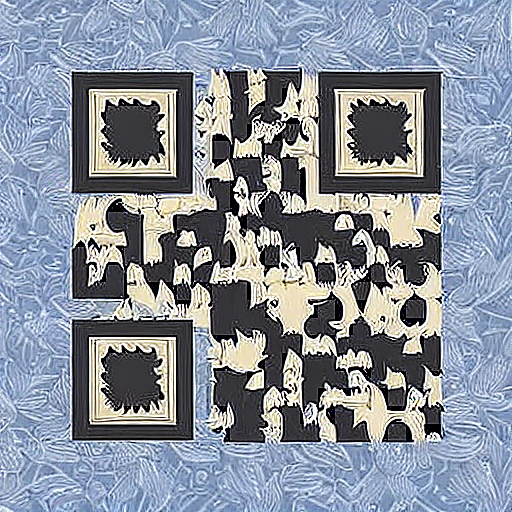


Generated QR Code Image
QR Data: podder

Original QR Code (for comparison):


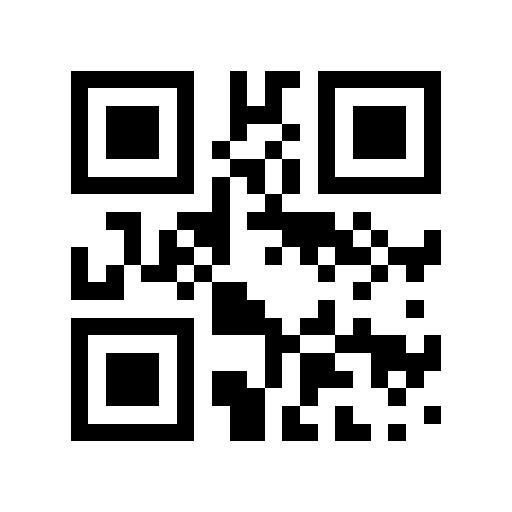

In [120]:
# Display the generated image
from IPython.display import Image as IPImage, display

display(IPImage(output_path, width=512))
print(f"\nGenerated QR Code Image")
print(f"QR Data: {QR_DATA}")

# Also display original QR for comparison
qr_ref_path = output_path.replace('.png', '_original_qr.png')
if os.path.exists(qr_ref_path):
    print("\nOriginal QR Code (for comparison):")
    display(IPImage(qr_ref_path, width=256))


In [121]:
# Validate QR code scannability (matching API validation - see app.py line 372-383)
# API uses QRCodeValidator.validate_qr_code() and assess_scannability_level()
if VALIDATE_QR:
    try:
        import cv2
        print("\n" + "=" * 60)
        print("QR Code Validation (Matching API)")
        print("=" * 60)
    
    def preprocess_image_for_qr(img):
        """Preprocess image to improve QR code detection."""
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply adaptive thresholding to enhance contrast
        adaptive_thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )
        
        # Also try Otsu's thresholding
        _, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Increase contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        contrast_enhanced = clahe.apply(gray)
        
        return [img, gray, adaptive_thresh, otsu_thresh, contrast_enhanced]
    
    def validate_qr(image_path, expected_data=None):
        """Validate QR code scannability using OpenCV with preprocessing."""
        img = cv2.imread(image_path)
        if img is None:
            return {"scannable": False, "error": "Could not read image"}
        
        detector = cv2.QRCodeDetector()
        
        # Try different preprocessing methods
        processed_images = preprocess_image_for_qr(img)
        methods = ["Original", "Grayscale", "Adaptive Threshold", "Otsu Threshold", "Contrast Enhanced"]
        
        for processed_img, method_name in zip(processed_images, methods):
            # Try detectAndDecodeMulti first (returns 4 values)
            try:
                retval, decoded_info, points, straight_qrcode = detector.detectAndDecodeMulti(processed_img)
                if retval and decoded_info is not None:
                    # decoded_info is a tuple/list of strings
                    for info in decoded_info:
                        if info is not None:
                            # Handle both string and numpy array cases
                            if isinstance(info, str):
                                decoded_str = info.strip()
                            elif isinstance(info, (np.ndarray, list, tuple)):
                                # Check if it's coordinates (numbers) - skip those
                                if len(info) > 0:
                                    first_elem = info[0] if hasattr(info, '__getitem__') else info
                                    if isinstance(first_elem, (int, float, np.number)):
                                        # This is likely points, not decoded data - skip
                                        continue
                                    else:
                                        decoded_str = str(info).strip()
                                else:
                                    continue
                            else:
                                decoded_str = str(info).strip()
                            
                            # Only accept if it's a reasonable string (not coordinates)
                            # Check if it looks like coordinates (contains brackets and numbers)
                            is_coordinates = ('[' in decoded_str and ']' in decoded_str) or \
                                           (decoded_str.replace('.', '').replace('-', '').replace(' ', '').replace('[', '').replace(']', '').isdigit())
                            
                            if len(decoded_str) > 0 and not is_coordinates:
                                matches = (decoded_str == expected_data) if expected_data else True
                                return {
                                    "scannable": True,
                                    "data_decoded": decoded_str,
                                    "matches_expected": matches,
                                    "method": f"OpenCV (Multi, {method_name})"
                                }
            except (ValueError, cv2.error, TypeError):
                pass
            
            # Try single decode (returns 3 values: retval, decoded_info, points)
            try:
                retval, decoded_info, points = detector.detectAndDecode(processed_img)
                # Check if retval is True and decoded_info is not empty
                if retval and decoded_info is not None:
                    # Handle both string and numpy array cases
                    if isinstance(decoded_info, str):
                        decoded_str = decoded_info.strip()
                    elif isinstance(decoded_info, (np.ndarray, list, tuple)):
                        # If it's an array, it might be points - skip it
                        # Try to extract string if it's a structured array
                        if len(decoded_info) > 0:
                            # Check if first element looks like coordinates (numbers)
                            first_elem = decoded_info[0] if hasattr(decoded_info, '__getitem__') else decoded_info
                            if isinstance(first_elem, (int, float, np.number)):
                                # This is likely points, not decoded data - skip
                                continue
                            else:
                                decoded_str = str(decoded_info).strip()
                        else:
                            continue
                    else:
                        decoded_str = str(decoded_info).strip()
                    
                    # Only accept if it's a reasonable string (not coordinates)
                    # Check if it looks like coordinates (contains brackets and numbers)
                    is_coordinates = ('[' in decoded_str and ']' in decoded_str) or \
                                   (decoded_str.replace('.', '').replace('-', '').replace(' ', '').replace('[', '').replace(']', '').isdigit())
                    
                    if len(decoded_str) > 0 and not is_coordinates:
                        matches = (decoded_str == expected_data) if expected_data else True
                        return {
                            "scannable": True,
                            "data_decoded": decoded_str,
                            "matches_expected": matches,
                            "method": f"OpenCV ({method_name})"
                        }
            except (cv2.error, ValueError, TypeError) as e:
                continue
        
        return {"scannable": False, "error": "Could not decode QR code after preprocessing", "method": "OpenCV"}
    
    # Validate using OpenCV with preprocessing (matching API validation)
    print(f"Validating QR code: {output_filename}")
    print(f"Expected data: {QR_DATA}")
    result = validate_qr(output_path, QR_DATA)
    
    # Display results
    print("\n" + "="*60)
    print("QR Code Validation Results")
    print("="*60)
    print(f"Scannable: {'✅ YES' if result['scannable'] else '❌ NO'}")
    if result.get('data_decoded'):
        print(f"Decoded Data: {result['data_decoded']}")
        if 'matches_expected' in result:
            print(f"Matches Expected: {'✅ YES' if result['matches_expected'] else '❌ NO'}")
    if result.get('method'):
        print(f"Method Used: {result['method']}")
    if result.get('error'):
        print(f"Error: {result['error']}")
    print("="*60)
    
    # Provide recommendations
    if not result['scannable']:
        print("\n💡 Recommendations to improve scannability:")
        print("   Current settings: CONDITIONING_SCALE={}, ENHANCEMENT_STRENGTH={}".format(
            CONTROLNET_CONDITIONING_SCALE, QR_ENHANCEMENT_STRENGTH))
        if CONTROLNET_CONDITIONING_SCALE < 2.0:
            print("   1. Try maximum CONTROLNET_CONDITIONING_SCALE = 2.0 (API max)")
        if QR_ENHANCEMENT_STRENGTH < 0.30:
            print("   2. Try maximum QR_ENHANCEMENT_STRENGTH = 0.30 (API max: 0.3)")
        print("   3. ⚠️  IMPORTANT: Test with a phone camera!")
        print("      Phone scanners are often more tolerant than OpenCV validation")
        print("      Many artistic QR codes work on phones even if validation fails")
        print("   4. Try post-processing method with subtlety = 0.85")
        print("   5. Consider using a simpler prompt (less artistic elements)")
    elif result.get('data_decoded') and not result.get('matches_expected', True):
        # QR detected but data doesn't match (might be coordinates)
        print("\n⚠️  QR code structure detected but data could not be decoded.")
        print("   This means the QR pattern is visible but too subtle for OpenCV to read.")
        print("   💡 Try testing with a phone camera - it often works better!")
    
        print("\nNote: PyZBar requires system libraries not available on Kaggle.")
        print("Using OpenCV for validation, which is more reliable in this environment.")
        print("API uses QRCodeValidator class for validation (see qr_validator.py)")
    
    except ImportError as e:
        print(f"⚠️  QR validation libraries not available: {e}")
        print("   Install opencv-python-headless for validation.")
    except Exception as e:
        print(f"⚠️  Validation error: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\n⚠️ Validation skipped (VALIDATE_QR=False)")
    print("   Set VALIDATE_QR=True to enable validation (API default: True)")


SyntaxError: expected 'except' or 'finally' block (956704244.py, line 10)

## Notes

- **Output files** are saved to `/kaggle/working/outputs/`
- **Models** are cached in `/kaggle/working/hf_cache/`
- **GPU** is automatically detected and used if available
- **This notebook matches the API implementation** (see `app.py` for reference)
- **ControlNet** method generally produces more scannable QR codes

## API Parameter Ranges (Matching app.py)

### Post-Processing Method (`use_controlnet=False`)
- `subtlety`: 0.85-0.95 (API default: 0.92) - lower = more visible QR

### ControlNet Method (`use_controlnet=True`)
- `controlnet_conditioning_scale`: 0.5-2.0 (API default: 1.5) - higher = stronger QR structure
- `qr_enhancement_strength`: 0.0-0.3 (API default: 0.15) - higher = more visible QR

### Common Parameters
- `image_size`: 256-1024 (API default: 512)
- `num_inference_steps`: 20-100 (API default: 50)
- `guidance_scale`: 1.0-20.0 (API default: 7.5)
- `seed`: Optional[int] (API default: None for random)
- `validate_qr`: bool (API default: True)

## Tips for Better Scannability

1. **Use ControlNet** (`use_controlnet=True`) for better results
2. **Maximum settings** for best scannability:
   - `controlnet_conditioning_scale = 2.0` (API max)
   - `qr_enhancement_strength = 0.30` (API max: 0.3)
3. **For post-processing**: Lower `subtlety` (0.85-0.88) for more visible QR
4. **Test with phone camera** - sometimes works even if validation fails

## API Usage

To use the API instead of this notebook:
```python
import requests

response = requests.post("http://localhost:8000/api/v1/generate", json={
    "prompt": "A dog in the sky with clouds",
    "qr_data": "https://example.com",
    "use_controlnet": True,
    "controlnet_conditioning_scale": 2.0,
    "qr_enhancement_strength": 0.30,
    "validate_qr": True
})
```
